In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

In [2]:
from AFML_module.dataset_utilities import (get_instrument_attributes, 
                                           form_dollar_bars, 
                                           form_time_bars,
                                           form_vol_bars,
                                           reduce_to_active_symbols, 
                                           apply_roll_factors)

from AFML_module.triple_barrier_utilities import (get_daily_rolling_volatility,
                                                  get_vertical_barriers,
                                                  detect_crossed_barriers_for_events)

from AFML_module.cusum_filter import apply_cusum_filter

In [3]:
from AFML_module.config import RAW_DATA_DIR

data = pd.read_parquet(RAW_DATA_DIR/"sp_emini_data.parquet", engine="pyarrow")
instrument_frame = pd.read_parquet(RAW_DATA_DIR/"instrument_frame.parquet", engine="pyarrow")

In [4]:
dollar_bars = form_dollar_bars(data, 300*10_000_000, sort=True)
active_only_dollar_bars = reduce_to_active_symbols(dollar_bars, instrument_frame)
rolled_dollar_bars = apply_roll_factors(active_only_dollar_bars, sort=False)

In [5]:
rolling_vol = get_daily_rolling_volatility(rolled_dollar_bars)

# Exercises

### 3.1, 3.3

Form dollar bars for E-mini S&P 500 futures:

(a) Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the
threshold is the standard deviation of daily returns (Snippet 3.1).

(b) Use Snippet 3.4 on a pandas series t1, where numDays=1.

(c) On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.

(d) Apply getBins to generate the labels.

3.3 -  Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical
barrier is the one touched first.
    --> __Done in triple_barrier_utilities.py__

Text(0.5, 0, 'Bar Number')

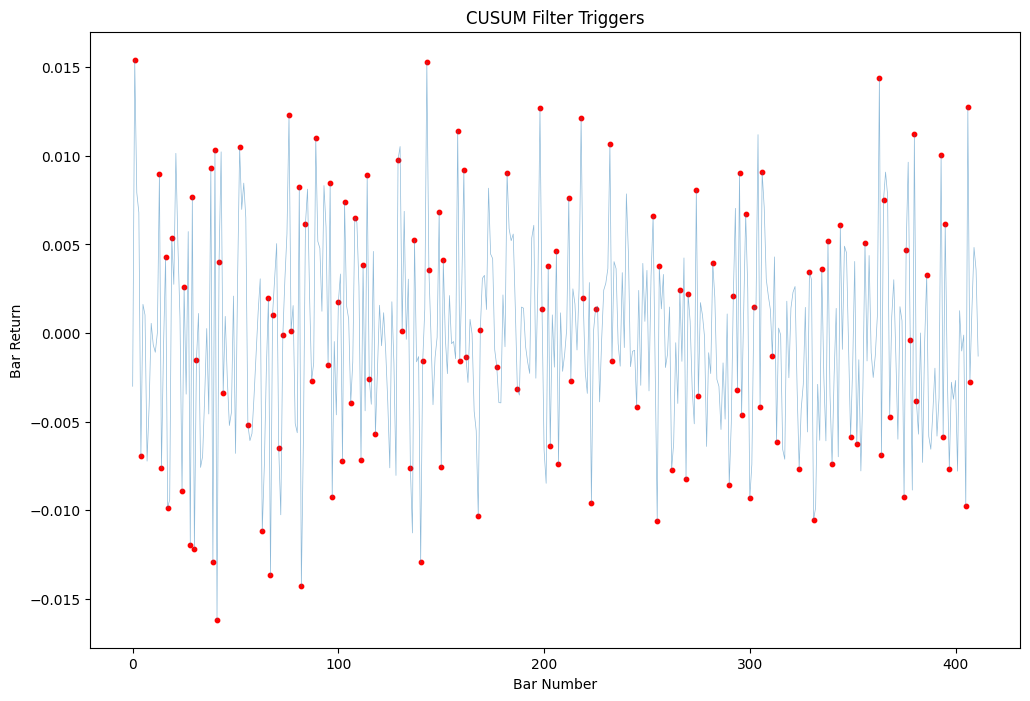

In [6]:
# First we sample events using the CUSUM filter from before
events = apply_cusum_filter(rolled_dollar_bars, 0.01)

plt.figure(figsize=(12, 8))
plt.plot(rolled_dollar_bars["return"], linewidth=0.5, alpha=0.5)
plt.scatter(events, rolled_dollar_bars.loc[events]["return"], s=10, color="red")

plt.title("CUSUM Filter Triggers")
plt.ylabel("Bar Return")
plt.xlabel("Bar Number")

In [7]:
# set the lower and upper thresholds to be the standard deviation of returns
# set the vertical barrier to be one day away from an event observation

lower_series = rolling_vol["daily volatility"]
upper_series = rolling_vol["daily volatility"]
vertical_barriers = get_vertical_barriers(rolled_dollar_bars, time_thresh="1d")

upper_factor = 1
lower_factor = 1

labelled_events = detect_crossed_barriers_for_events(rolled_dollar_bars, 
                                                     events, 
                                                     lower_series, 
                                                     upper_series, 
                                                     lower_factor, 
                                                     upper_factor,
                                                     vertical_barriers)

Text(0.5, 0, 'Dollar Bar Number')

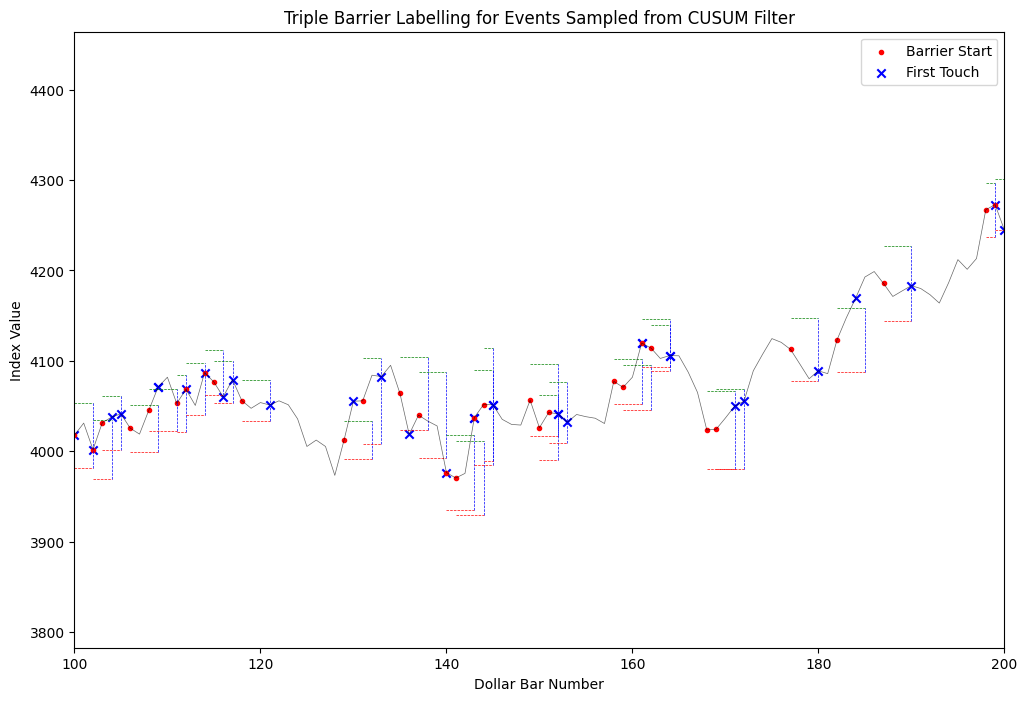

In [8]:
plt.figure(figsize=(12, 8))

lower_barriers = rolled_dollar_bars["close"]*(1 - lower_series * lower_factor)
upper_barriers = rolled_dollar_bars["close"]*(1 + upper_series * upper_factor)

for idx, event in enumerate(events):
        
    box_vertical_barrier = vertical_barriers[event]
    box_lower_barrier = lower_barriers[event]
    box_upper_barrier = upper_barriers[event]

    start_label = "Barrier Start" if idx == 0 else "_nolegend_"
    plt.scatter(event, rolled_dollar_bars.loc[event, "close"], marker=".", color="red", label=start_label)

    
    plt.plot(
        [i for i in range(event, box_vertical_barrier+1)],
        [box_lower_barrier for _ in range(event, box_vertical_barrier+1)],
        color='r', linestyle='--', linewidth=0.5
    )

    plt.plot(
        [i for i in range(event, box_vertical_barrier+1)],
        [box_upper_barrier for _ in range(event, box_vertical_barrier+1)],
        color='g', linestyle='--', linewidth=0.5
    )

    touch_label = "First Touch" if idx == 0 else "_nolegend_"
    plt.scatter(
        labelled_events.loc[event, "first touch"],
        rolled_dollar_bars.loc[labelled_events.loc[event, "first touch"]]["close"],
        marker="x", color="blue", label=touch_label
    )
    
    # vertical line only between barriers
    plt.vlines(
        x=box_vertical_barrier,
        ymin=box_lower_barrier,
        ymax=box_upper_barrier,
        color="b", linestyle="--", linewidth=0.5
    )


plt.plot(rolled_dollar_bars["close"], color='black', linewidth=0.5, alpha=0.6)
    
plt.legend()
    
plt.xlim(100, 200)

plt.title("Triple Barrier Labelling for Events Sampled from CUSUM Filter")
plt.ylabel("Index Value")
plt.xlabel("Dollar Bar Number")

### 3.4

Develop a trend-following strategy based on a popular technical analysis statistic
(e.g., crossing moving averages). For each observation, the model suggests a side,
but not a size of the bet.

(a) Derive meta-labels for ptSl=[1,2] and t1 where numDays=1. Use as
trgt the daily standard deviation as computed by Snippet 3.1.

(b) Train a random forest to decide whether to trade or not. Note: The decision
is whether to trade or not, {0,1}, since the underlying model (the crossing
moving average) has decided the side, {−1,1}.


__Note__: This exercise is done as a demonstration of the steps to employ metalabelling. It is NOT meant to demonstrate a strategy or a statistically significant discovery __at all__

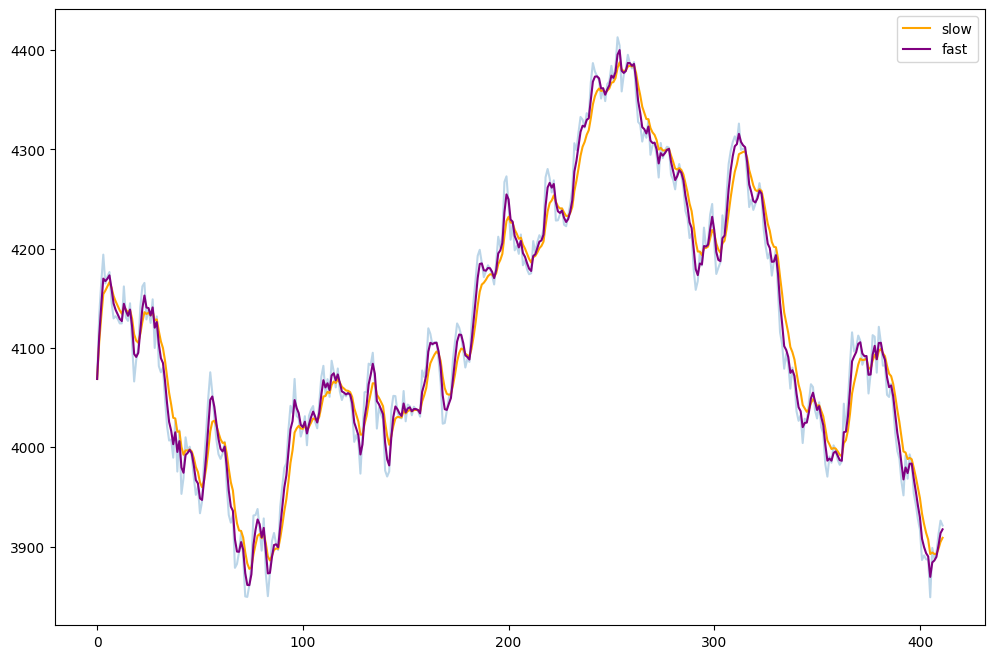

In [9]:
# Define a fast and slow moving average. Our event sampling rule will be when the fast 
# average moves above the slow average

slow = rolled_dollar_bars["close"].ewm(3).mean() # about 30 hours
fast = rolled_dollar_bars["close"].ewm(1).mean() # about 10 hours

up_crosses = rolled_dollar_bars[(fast>=slow) & (fast.shift(1)<slow.shift(1))].index
down_crosses = rolled_dollar_bars[(fast<=slow) & (fast.shift(1)>slow.shift(1))].index

plt.figure(figsize=(12, 8))


plt.plot(rolled_dollar_bars["close"], alpha=0.3)
plt.plot(slow, label="slow", color="orange") 
plt.plot(fast, label="fast", color="purple")

plt.legend()

In [10]:
# When the fast moving average goes above the slow, we take the long side
# when the fast moving average goes below the slow, we take the short side

total_events = sorted(list(up_crosses) + list(down_crosses))

event_side_frame = pd.DataFrame(index=total_events, columns=["side"])
event_side_frame.loc[up_crosses, "taken side"] = 1
event_side_frame.loc[down_crosses, "taken side"] = -1


In [11]:
# Form the triple barriers and measure crossings

lower_series = rolling_vol["daily volatility"]
upper_series = rolling_vol["daily volatility"]
vertical_barriers = get_vertical_barriers(rolled_dollar_bars, time_thresh="3d")


upper_factor = 0.5
lower_factor = 1

labelled_events = detect_crossed_barriers_for_events(rolled_dollar_bars, 
                                                     event_side_frame.index, 
                                                     lower_series, 
                                                     upper_series, 
                                                     lower_factor, 
                                                     upper_factor,
                                                     vertical_barriers)

labelled_events = labelled_events.dropna()

labelled_events["taken side"] = event_side_frame["taken side"]

Text(0.5, 0, 'Dollar Bar Number')

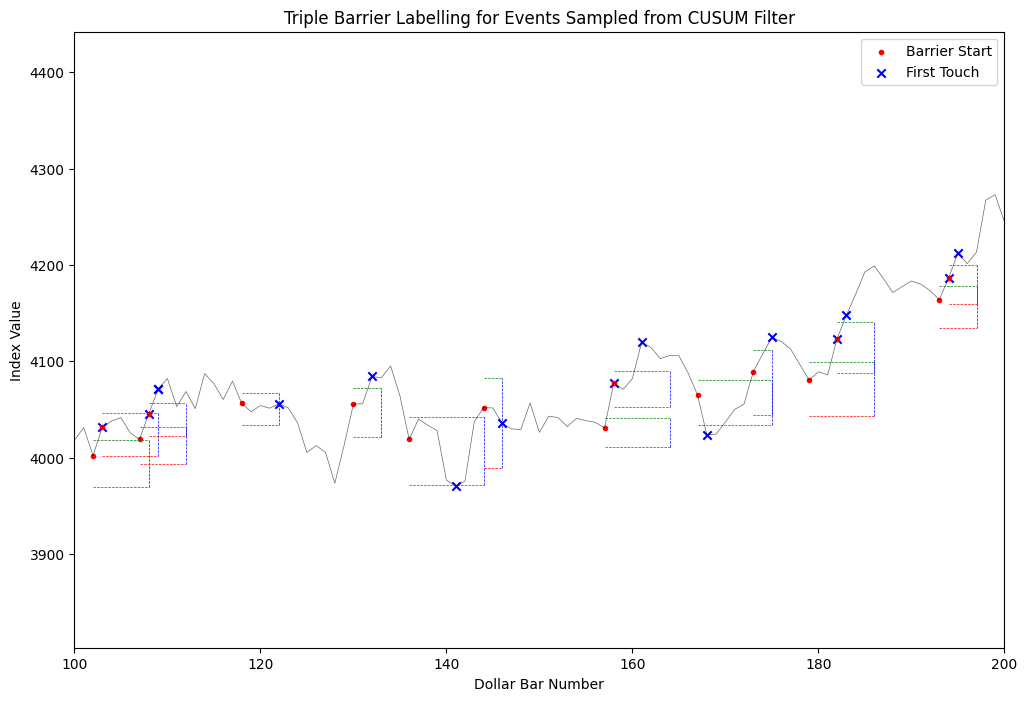

In [12]:
plt.figure(figsize=(12, 8))

lower_barriers = rolled_dollar_bars["close"]*(1 - lower_series * lower_factor)
upper_barriers = rolled_dollar_bars["close"]*(1 + upper_series * upper_factor)

for idx, event in enumerate(total_events):
       
        
    try:    
        box_vertical_barrier = vertical_barriers[event]
        box_lower_barrier = lower_barriers[event]
        box_upper_barrier = upper_barriers[event]
    except KeyError:
        continue
        
        
    start_label = "Barrier Start" if idx == 0 else "_nolegend_"
    plt.scatter(event, rolled_dollar_bars.loc[event, "close"], marker=".", color="red", label=start_label)

    
    plt.plot(
        [i for i in range(event, box_vertical_barrier+1)],
        [box_lower_barrier for _ in range(event, box_vertical_barrier+1)],
        color='r', linestyle='--', linewidth=0.5
    )

    plt.plot(
        [i for i in range(event, box_vertical_barrier+1)],
        [box_upper_barrier for _ in range(event, box_vertical_barrier+1)],
        color='g', linestyle='--', linewidth=0.5
    )

    touch_label = "First Touch" if idx == 0 else "_nolegend_"
    plt.scatter(
        labelled_events.loc[event, "first touch"],
        rolled_dollar_bars.loc[labelled_events.loc[event, "first touch"]]["close"],
        marker="x", color="blue", label=touch_label
    )
    
    # vertical line only between barriers
    plt.vlines(
        x=box_vertical_barrier,
        ymin=box_lower_barrier,
        ymax=box_upper_barrier,
        color="b", linestyle="--", linewidth=0.5
    )


plt.plot(rolled_dollar_bars["close"], color='black', linewidth=0.5, alpha=0.6)
    
plt.legend()

plt.xlim(100, 200)

plt.title("Triple Barrier Labelling for Events Sampled from CUSUM Filter")
plt.ylabel("Index Value")
plt.xlabel("Dollar Bar Number")

In [20]:
# We use this simple rule to determine the side of the bet
# idea is to start with a model that has a lot of false positives (i.e. low precision)
# and then improve the precision through meta labelling

actuals = labelled_events["barrier"].astype(int)
predicted = labelled_events["taken side"].astype(int)

cm = confusion_matrix(actuals, 
                      predicted,
                      labels=[1, -1]) 

print("Correctly Classified: ", (cm[0,0] + cm[1,1])/ labelled_events.shape[0], "\n")

precision, recall, f1, support = precision_recall_fscore_support(
    actuals, predicted, labels=[1, -1]
)

print("Precision (1, -1):", precision) # TP / (TP + FP)
print("Recall    (1, -1):", recall) # TP / (TP + FN)
print("F1-score  (1, -1):", f1)
print("Support   (1, -1):", support)


Correctly Classified:  0.4339622641509434 

Precision (1, -1): [0.61538462 0.25925926]
Recall    (1, -1): [0.5    0.4375]
F1-score  (1, -1): [0.55172414 0.3255814 ]
Support   (1, -1): [32 16]


In [17]:
# For demonstration, use windowed autocorrelation feature on square returns and daily volatility as the features
best_lag = acf(np.power(rolled_dollar_bars["return"], 2)).argsort()[-2]

def autocorr_lag(x, lag):
    return x.autocorr(lag=lag)

windowed_autocorrelation = rolled_dollar_bars["return"].diff(1).rolling(window=2*best_lag, center=False).apply(lambda x: autocorr_lag(x, best_lag), raw=False)

labelled_events["autocorrelation"] = windowed_autocorrelation
labelled_events["volatility"] = rolling_vol["daily volatility"]

labelled_events["should trade"] = (labelled_events["taken side"] == labelled_events["barrier"])

In [27]:
features = ["taken side", "autocorrelation", "volatility"]

meta_data = labelled_events.dropna() 
X_train, X_test, y_train, y_test = train_test_split(meta_data[features], meta_data['should trade'], test_size=.7)

bst = XGBClassifier(n_estimators=50, max_depth=2, learning_rate=0.01, objective='binary:logistic')
bst.fit(X_train, y_train)

preds = bst.predict(X_test)

cm = confusion_matrix(y_test, 
                      preds,
                      labels=[1,0]) 

print("Correctly Classified: ", (cm[0,0] + cm[1,1])/ preds.shape[0], "\n")

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, preds, labels=[1]
)

print("Precision:", precision) # TP / (TP + FP)
print("Recall:", recall) # TP / (TP + FN)
print("F1-score:", f1)
print("Support:", support)

Correctly Classified:  0.6363636363636364 

Precision: [0.53333333]
Recall: [0.61538462]
F1-score: [0.57142857]
Support: [13]


Accuracy and F1 score are slightly higher, but this is actually at the expense of precision; clearly this experiment did not work.
Obviously, this requires a lot more data, and a lot more feature engineering, to even make a false discovery.
